## Goal

* A detailed understanding of the improvements made in this paper over [DDPM.](https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch?rvi=1)

* Implementation of the paper [Diffusion Models Beat GANs on Image Synthesis](https://openreview.net/pdf?id=AAWuCvzaVt) from scratch in PyTorch.

* Train the Diffusion Model from Scratch in PyTorch as described in the [paper](https://openreview.net/pdf?id=AAWuCvzaVt).

* Generate Samples from the trained diffusion model.

* Evaluate the quality of the generated samples.

## Overview

* [Diffusion Models Beat GANs on Image Synthesis](https://openreview.net/pdf?id=AAWuCvzaVt) paper builds upon the earlier paper [Improved Denoising Diffusion Probabilistic Models](https://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf) by the same authors from OpenAI.

* [Improved Denoising Diffusion Probabilistic Models](https://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf) introduced several improvements over DDPM such as **Cosine Noise Schedular, Learnt Variance, and Improved Sampling Speed.** 

* Later [Diffusion Models Beat GANs on Image Synthesis](https://openreview.net/pdf?id=AAWuCvzaVt) proposes further improvements such as **Better Architecture and Classifier Guidance** which surpasses GANs at that time.

* In this notebook, we'll provide a brief explanation of  all of these improvements and implement them from scratch. Finally we will use them in training to witness the magic of Diffusion models firsthand.

## Improvements over [DDPM](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)

### 1. Cosine Noise Schedular

* DDPM utilizes a linear noise scheduler, wherein the parameter β controlling the noise is linearly sampled from the range **[1e-4, 0.02]**.

* The drawback of the Linear Noise scheduler is that it **deteriorates the image well before reaching the final time steps T**. Therefore, when observing images in the last few time steps, they mostly appear as noise.

* The author of the [paper](https://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf) also concluded that last 20% of the timesteps is not useful and can be skipped during reverse process without compromising the performance.

* To tackle this issue and make every timestep count, **Cosine Noise Schedular** is proposed which **prevents destroying the whole image information well before reaching the final timestep**.

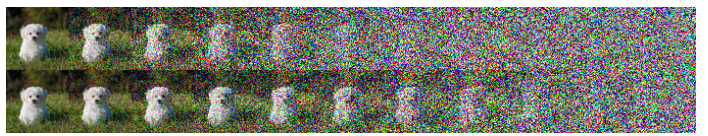

                       Linear (Top) vs Cosine (Bottom) Schedular
                       
* Author designs the Cosine Noise Schedular as follows:

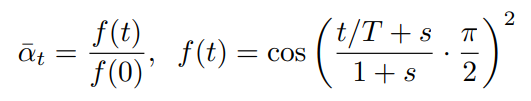

* Then Noise Controlling parameter β is calculated by the following equation:

$$
\beta_{t} = 1 - \frac{\bar{\alpha}_{t}}{\bar{\alpha}_{t-1}}
$$


### 2. Learnt Variance through Hybrid-Loss

* In the [DDPM paper](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf), the variance Σ is kept **constant** and set to either forward process variance β<sub>t</sub> or forward posterior variance β<sup>~</sup><sub>t</sub>.

* Both choices of variance yielded almost similar results according to the DDPM paper which is bit unusual considering β<sub>t</sub> and β<sup>~</sup><sub>t</sub> are two opposite extremes.

* According to [this paper](https://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf), the reason behind this is that for simple MSE loss, the choice of Σ doesn't matter much. However, the choice of Σ can be crucial in improving the log-likelihood.

* To achieve this, author chooses to learn the variance Σ through neural network instead of setting it to the constant.

* Author chooses to parametrize the variance as an **interpolation of β<sub>t</sub> and β<sup>~</sup><sub>t</sub> in log domain**. (May be experimental?) and the **v** is learnt through neural network as shown below.

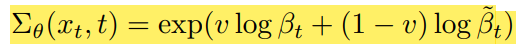

* Since current objective of **Simple MSE Loss doesn't depend on the Σ** so author proposed the **hybrid loss which depends on the Σ also**. The hybrid loss is the weighted sum of MSE Loss and Variational Lower bound Loss as shown below.


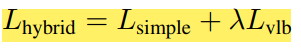

* According to the author, **Learning Variance through hybrid loss allowed the diffusion model to sample with fewer steps without much drop in the sample quality.**

* In paper, the author uses **250 reverse steps** during sampling as compared to the 1000 in the DDPM paper. (It mean the sampling time is reduced by 3/4th times). **Note that During training the complete 1000 forward steps are utilized but the sampling is done using 250 reverse steps only**.

### 3. Improved Sampling Speed

* As discussed in the last section, Improved sampling speed is the result of learnt variance through hybrid loss.

* It allows the diffusion model to sample with much fewer steps (250 in paper) than they were trained with (typically 1000).

* The question now is: which 250 steps should we use? A straightforward approach would be to choose 250 evenly spaced steps between 1 and 1000. However, this method is sub-optimal. The author suggests a more effective strategy: **taking larger steps at the beginning of the reverse process and progressively smaller steps as you approach x<sub>0</sub>.**

* The rationale behind this strategy is that at the beginning of the reverse process, there is more noise, allowing for skipping steps. However, as you get closer to x<sub>0</sub>, the noise decreases, and taking larger steps might remove important image information along with the noise.

* when sampling with fewer steps, the parameter β<sub>t</sub> also needs to be modified accordingly as shown below.

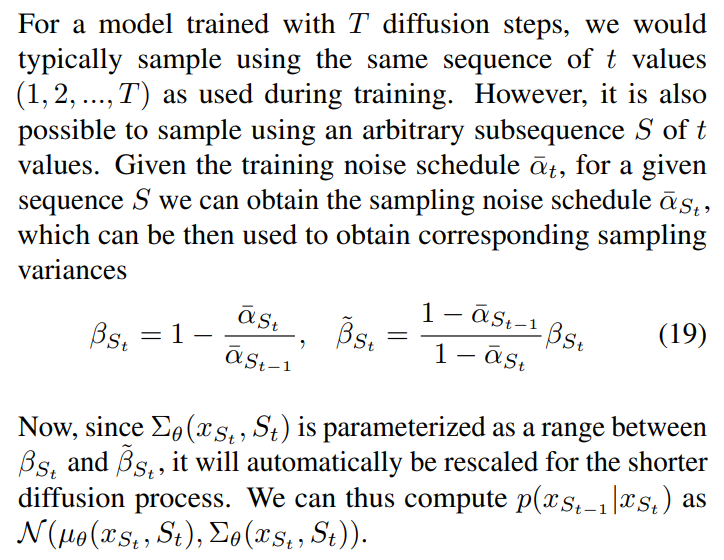


### 4. Class Embedding + Adaptive GroupNorm in U-net

* As we have seen in the [DDPM implementation](https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch#Model-Architecture) that timesteps information was utilised in the Unet architecture for predicting noise.  

* In this paper, Author also utilizes **class label information** in the U-net. First the class labels are converted into embedding through nn.Embedding Layer and merged with Timestep embedding through addition.

* Author also uses **Adaptive Instance Normalization (AdaIn)** while merging the Embedding with features extracted (inside the Resnet Block of the U-net). AdaIn basically aligns the mean and variance of the features with Embeddings.

* The extracted features and Projection of the Embeddings (timesteps + label) are merged in the following manner. where scale and shift are obtained from Projection of the Embeddings.

$$\text{GroupNorm}(features) * (scale + 1) + shift$$

* Author mentioned that using this technique slightly improved the FID score.

* We will understand this more clearly during implementation of the same.


### 5. Classifier Guidance

* It is a process of guiding the diffusion process towards an arbitrary class label y through a pretrained classifier.

* In this process, first a classifier is trained on noisy images obtained from diffusion forward Process and labels.

* Then Diffusion Model is trained as usual. (No need to do anything extra)

* Finally they use **gradient of the pretrained classifier to guide the diffusion process during sampling**. The sampling is done using the following distribution.

$$ N(\mu + \Sigma g, \Sigma) $$

* So here they **shifted the mean of diffusion process by Σg**. where g is gradient of the image contributing to that particular class label y. Note that here µ and Σ are the estimated mean and variance of the diffusion reverse process.

* According to the paper, Classifier guidance improved the precision at the cost of recall. i.e. **generated better looking samples but less diverse**, thus introducing a trade-off in sample fidelity versus diversity.

* They also mentioned that it is also crucial to **scale the classfier gradient by a factor more than 1** to generate images of a given class label with high probability.

Now Let's get into the implementation part.

## Classifier Guided Diffusion Process

* Let's first list all the utilities we're gonna need in order to implement classifier guided diffusion process.

 1. Cosine Noise Schedular $\checkmark$
 2. Forward Process $\checkmark$
 3. q_posterior mean variance $\checkmark$
 4. p mean variance $\checkmark$
 5. sample prev timestep $\checkmark$
 6. Variation Lower Bound loss $\checkmark$
 7. Hybrid Loss $\checkmark$

**Cosine Noise Schedular**

In [1]:
import math
import numpy as np

def sample_timesteps(num_total_timesteps: int = 1000,
                     num_sample_timesteps: int = 1000
                    ):
    """
    Uniformaly sample num_sample_timesteps timesteps given 
    total number of timesteps.
    Later we will utilize for speed up sampling.
    """
    # Get New sampled timesteps (Uniform stepping)
    step_size = num_total_timesteps//num_sample_timesteps
    use_timesteps = np.arange(0, num_total_timesteps, step_size)
    
    # Make sure to append final timestep if not there already
    if (num_total_timesteps - 1) not in use_timesteps:
        use_timesteps = np.append(use_timesteps, num_total_timesteps - 1)
        
    return use_timesteps

#---------------------------------------------------------------------------


def cosine_noise_schedular(num_original_timesteps: int = 1000, 
                           num_sampling_timesteps: int = 1000, 
                           max_beta: float = 0.999
                          ) -> np.ndarray:
    """
    Calculate noise controlling parameter betas for all time steps 
    according to the cosine noise scheduler.

    Parameters:
    num_original_timesteps (int): Number of original diffusion timesteps (used during training).
    num_sampling_timesteps (int): Number of timesteps used for sampling.
    max_beta (float): Maximum value for beta.

    Returns:
    array: Beta values for each timestep.
    array: timesteps used to calculate betas.
    
    NOTE: Set "num_sampling_timesteps" = "num_original_timesteps" during training.
    """
    # s is set to 0.008 by Authors
    s = 0.008
    
    # Calculate alpha bars
    alpha_bars = [
        math.cos(((t / num_original_timesteps + s) / (1 + s)) * (math.pi / 2)) ** 2 
        for t in range(num_original_timesteps + 1)
    ]
    
    # Calculate betas
    betas = np.array([
        min(1 - a_t / a_tminus1, max_beta) 
        for a_t, a_tminus1 in zip(alpha_bars[1:], alpha_bars[:-1])
    ])
    
    # Modify Betas as described in the "Improved Sampling Speed" section above.
    alphas = 1 - betas
    alphas_cumprod = np.cumprod(alphas, axis=0)
    
    # Get New sampled timesteps (Uniform stepping)
    use_timesteps = sample_timesteps(num_original_timesteps, 
                                     num_sampling_timesteps
                                    )

    # Calculate new betas according to new timesteps.
    last_alpha_cumprod = 1.0
    new_betas = []
    for i, alpha_cumprod in enumerate(alphas_cumprod):
        if i in use_timesteps:
            new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
            last_alpha_cumprod = alpha_cumprod
    
    return np.array(new_betas), use_timesteps

**Codeblock for Variational Lower Bound Loss:**

In [2]:
"""
Helpers for various likelihood-based losses. These are ported from the original
Ho et al. diffusion models codebase:
https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/utils.py
"""

import numpy as np

import torch


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, torch.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, torch.Tensor) else torch.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + torch.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * torch.exp(-logvar2)
    )


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.

    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(
        x < -0.999,
        log_cdf_plus,
        torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

**Guided Diffusion Process Class**

In [3]:
import torch.nn.functional as F

class GuidedDiffusionProcess:
    """
    Utilities for training and sampling diffusion model.
    Ported directly from https://github.com/openai/guided-diffusion/blob/main/guided_diffusion/gaussian_diffusion.py
    and modified for simplicity.
    """
    def __init__(self, 
                 num_timesteps:int = 1000,
                 num_sampling_timesteps:int = 1000,
                 classifier_guidance: bool = False, # True for Classifier Guidance during sampling only.
                 classifier_scale = 1.0 # Weight given to the classifier gradient 
                ):
        
        # Classifier Guidance.
        self.classifier_guidance = classifier_guidance
        self.classifier_scale = classifier_scale
        
        # Betas using Cosine Noise Schedular
        self.betas, self.use_timesteps = cosine_noise_schedular(num_timesteps, num_sampling_timesteps)
        self.betas = torch.tensor(self.betas, dtype=torch.float32)
        self.use_timesteps = torch.tensor(self.use_timesteps, dtype=torch.float32)

        # Diffusion Process Coefficients.
        self.alphas = 1.0 - self.betas
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one_minus_alphas_cumprod = 1.0 - self.alphas_cumprod
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0/self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0/self.alphas_cumprod - 1)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(self.one_minus_alphas_cumprod)
        self.alphas_cumprod_prev = torch.cat((torch.tensor([1.]), self.alphas_cumprod[:-1]))
        self.sqrt_alphas_cumprod_prev = torch.sqrt(self.alphas_cumprod_prev)
        
        
        # calculation for forward process "posterior" q(x_{t-1} | x_{t}).        
        self.posterior_mean_coef1 = (self.sqrt_alphas_cumprod_prev * self.betas)/self.one_minus_alphas_cumprod
        self.posterior_mean_coef2 = (self.sqrt_alphas * (1.0 - self.alphas_cumprod_prev))/self.one_minus_alphas_cumprod
        self.posterior_variance = (self.betas * (1.0 - self.alphas_cumprod_prev))/(self.one_minus_alphas_cumprod)
        
        # Calculation for Variation Lower Bound Loss
        # log calculation clipped because the posterior variance is 0 at the
        # beginning of the diffusion chain.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat((self.posterior_variance[1].unsqueeze(0), self.posterior_variance[1:]))
        )
        
    def add_noise(self, x0, noise, t):
        
        """
        calculate x_t for all timesteps given input x0 using
        x_t = sqrt(abar_t) * x0 + sqrt(1 - abar_t) * epsilon
        where epsilon ~ N(0, 1). i.e., Forward Process
        
        Parameters:
        x0: Batch of Input Images of shape -> (B, C, H, W)
        noise: Batch of Noise sampled from N(0, 1) of shape -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)
        
        Return:
        xt: Batch of output images at timesteps t obtained 
        according to Diffusion Forward Process of shape -> (B, C, H, W)
        """
        # Mapping to Device + Broadcast
        sqrt_alphas_cumprod = self._coeff_broadcasting(self.sqrt_alphas_cumprod, t)
        sqrt_one_minus_alphas_cumprod = self._coeff_broadcasting(self.sqrt_one_minus_alphas_cumprod, t)
        
        # Return
        return (sqrt_alphas_cumprod * x0) + (sqrt_one_minus_alphas_cumprod * noise)
    
    def q_posterior_mean_variance(self, x0, xt, t):
        
        """
        Calculate Posterior Forward Mean and Variance of the
        Diffusion Process. i.e., q(x_(t-1)|x_t) Later we will use 
        this in defining Variational Lower Bound (VLB) loss.
        
        Parameters:
        x0: Batch of Input Images of shape -> (B, C, H, W)
        xt: Batch of images at timesteps t -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)
        
        Return:
        posterior_mean, posterior_variance, and posterior_log_variance_clipped
        of the shape -> (B, C, H, W)
        """
        
        posterior_mean_coef1 = self._coeff_broadcasting(self.posterior_mean_coef1, t)
        posterior_mean_coef2 = self._coeff_broadcasting(self.posterior_mean_coef2, t)
        posterior_variance = self._coeff_broadcasting(self.posterior_variance, t)
        posterior_log_variance_clipped = self._coeff_broadcasting(self.posterior_log_variance_clipped, t)
        
        # Posterior Mean
        posterior_mean = (posterior_mean_coef1 * x0) + (posterior_mean_coef2 * xt)
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    def p_mean_variance(self, model, x, t, y):
        
        """
        Calculation of Mean and Variance of p(x_(t-1)|x_t) using 
        model noise prediction.
        
        Params
        --------
        model: U-net model which predicts the noise
        x: signal at time step t of shape -> (B, C, H, W)
        t: Batch of timesteps of shape -> (B, 1)
        y: Batch of class labels of shape -> (B, 1)
        
        Return
        --------
        mean: the model mean output
        variance: the model variance output
        log_variance: the log of variance
        x0: prediction of x_start
        """
        B, C, H, W = x.shape
        
        out = model(x, self.scale_timestep(t), y) # Class conditional
        
        # Get Noise pred and Variance from out
        noise_pred, model_var_values = torch.split(out, C, dim=1)
        
        # Calculate x0
        sqrt_recip_alphas_cumprod = self._coeff_broadcasting(self.sqrt_recip_alphas_cumprod, t)
        sqrt_recipm1_alphas_cumprod = self._coeff_broadcasting(self.sqrt_recipm1_alphas_cumprod, t)
        pred_xstart = (sqrt_recip_alphas_cumprod * x) - (sqrt_recipm1_alphas_cumprod * noise_pred)
        pred_xstart = torch.clamp(pred_xstart, -1., 1.)
        
        # Calculate Mean
        model_mean, _, _ = self.q_posterior_mean_variance(pred_xstart, x, t)
        
        # Calculate Variance
        min_log_var = self._coeff_broadcasting(self.posterior_log_variance_clipped, t)
        max_log_var = self._coeff_broadcasting(torch.log(self.betas), t)
        frac = (model_var_values + 1)/2 # Convert the model_var_values from [-1, 1] -> [0, 1]
        model_log_variance = (frac * max_log_var) + ((1-frac) * min_log_var)
        model_variance = torch.exp(model_log_variance)
        
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart
        }
    
    def p_sample(self, model, x, t, y, classifier=None):
        
        """
        sample x_{t-1} from the model at given timestep.
        """
        out = self.p_mean_variance(model, x.float(), t, y)
        
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        
        # Shift the mean to Sigma * gradient
        if self.classifier_guidance:
            gradient = self._calc_gradient(x, self.scale_timestep(t), y, classifier) * self.classifier_scale
            out["mean"] = out["mean"].float() + out["variance"] * gradient.float()
       
        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}
    
    
    def _vb_terms_bpd(
        self, model, x_start, x_t, t, y
    ):
        """
        Get a term for the variational lower-bound.

        The resulting units are bits (rather than nats, as one might expect).
        This allows for comparison to other papers.

        :return: a dict with the following keys:
                 - 'output': a shape [N] tensor of NLLs or KLs.
                 - 'pred_xstart': the x_0 predictions.
        """
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
            x0=x_start, xt=x_t, t=t
        )
        out = self.p_mean_variance(
            model, x_t, t, y
        )
        kl = normal_kl(
            true_mean, true_log_variance_clipped, out["mean"], out["log_variance"]
        )
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = torch.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"]}
    
    def training_losses(self, model, x_start, t, noise, y):
        """
        MSE Loss and Variational Lower Bound Loss.
        """
        x_t = self.add_noise(x_start, noise, t)
        model_output = model(x_t.float(), self.scale_timestep(t), y)
        
        # Model Output and Variance
        B, C, H, W = x_start.shape
        model_output, model_var_values = torch.split(model_output, C, dim=1)
        
        # Learn the variance using the variational bound, but don't let
        # it affect our mean prediction.
        frozen_out = torch.cat([model_output.detach(), model_var_values], dim=1)
        vlb_loss = self._vb_terms_bpd(
            model=lambda *args, r=frozen_out: r,
            x_start=x_start,
            x_t=x_t,
            t=t,
            y=y
        )["output"]
        
        # Divide by 1000 for equivalence with initial implementation.
        # Without a factor of 1/1000, the VB term hurts the MSE term.
        #vlb_loss *= 1 / 1000.0
        
        # MSE Loss
        mse_loss = mean_flat((noise - model_output) ** 2)
        
        return { "mse_loss": mse_loss, "vlb_loss": vlb_loss}
    
    
    def scale_timestep(self, timestep):
        """
        This is to make sure we are feeding correct timestep
        to the model. (comes handy during sampling with lower timesteps)
        """
        return self.use_timesteps.to(timestep.device)[timestep]
    
    @staticmethod
    def _calc_gradient(x, t, y, classifier):
        """
        Calculate Classifier Gradient of the image x at timestep t.
        """
        with torch.enable_grad():
            x_in = x.detach().requires_grad_(True)
            logits = classifier(x_in, t)
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            return torch.autograd.grad(selected.sum(), x_in)[0]
        
    @staticmethod
    def _coeff_broadcasting(coeff, timesteps):
        
        """
        Device Mapping and Broadcasting of the Diffusion 
        Process Coefficients to the same shape as Input tensors 
        (B, C, H, W).
        """
        
        # Make coef on the same device as timesteps
        coeff = coeff.to(timesteps.device)[timesteps]
        
        # Broadcast
        coeff = coeff[:,None, None, None]

        return coeff

## Unet Architecture

We'll use the same architecture that we used in our last notebook [here.](https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch) we'll make few changes in it to make it **class conditional** and also we have to separately build a classifier so we can use later during **classifier guidance**. we'll also use the **scale shift norm** as described above in Improvement section.

**Utility Modules**

In [4]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:
    
    """ 
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    
    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)
    
    :return tensor of size -> (B, t_emb_dim)
    """
    
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    
    factor = 2 * torch.arange(start = 0, 
                              end = t_emb_dim//2, 
                              dtype=torch.float32, 
                              device=time_steps.device
                             ) / (t_emb_dim)
    
    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1) 
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)
    
    return t_emb

In [5]:
import torch.nn as nn

class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 num_groups:int = 8, 
                 kernel_size: int = 3, 
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()
        
        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()
        
        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size, 
            padding=(kernel_size - 1)//2
        )
        
    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x
    
    # Making this class subscriptable for later use.
    def __getitem__(self, index):
        if index == 0:
            return self.g_norm
        elif index == 1:
            return nn.Sequential(self.act, 
                                 self.conv
                                )
        else:
            raise IndexError('Index out of range. Valid indices are 0, 1')
    
#-----------------------------------------------------------------

class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self, 
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()
        
        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(t_emb_dim, n_out)
        )
        
    def forward(self, x):
        return self.te_block(x)
    
#---------------------------------------------------------------

class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.    
    """
    def __init__(self, 
                 num_channels:int,
                 num_groups:int = 8, 
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()
        
        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads, 
            batch_first=True
        )
        
    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x
    
#----------------------------------------------------------------

class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_mpool = use_mpool
        
        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_mpool else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            )
        ) if use_conv else nn.Identity()
        
        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_mpool else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.mpool(x)
        
        if not self.use_mpool:
            return self.cv(x)
            
        return torch.cat([self.cv(x), self.mpool(x)], dim=1)
    
#-----------------------------------------------------------------------

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_upsample = use_upsample
        
        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels, 
                out_channels//2 if use_upsample else out_channels, 
                kernel_size = 1, 
                stride=1, 
                padding=0
            )
        ) if use_conv else nn.Identity()
        
        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k, 
                mode = 'bilinear', 
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_upsample else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.up(x)
        
        if not self.use_upsample:
            return self.cv(x)
        
        return torch.cat([self.cv(x), self.up(x)], dim=1)

**DownC Block**

In [6]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True, # True for Downsampling
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(DownC, self).__init__()
        
        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels, 
                          t_emb_dim
                         ) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, t_emb):
        
        out = x
        
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            emb_out = self.te_block[i](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i][0], self.conv2[i][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i](out)
                
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)
        
        return out

**MidC Block**

In [7]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:
    
    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding 
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2,
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(MidC, self).__init__()
        
        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers + 1)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels, 
                          t_emb_dim
                         ) for _ in range(num_layers + 1)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])
        
    def forward(self, x, t_emb):
        out = x
        
        # First-Resnet Block
        resnet_input = out
        
        # Resnet Block
        out = self.conv1[0](out)
        emb_out = self.te_block[0](t_emb)[:, :, None, None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.conv2[0][0], self.conv2[0][1]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            out = out_norm(out) * (1 + scale) + shift
            out = out_rest(out)
        else:
            out = out + emb_out
            out = self.conv2[0](out)

        out = out + self.res_block[0](resnet_input)

        
        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            emb_out = self.te_block[i+1](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i+1][0], self.conv2[i+1][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i+1](out)
                
            out = out + self.res_block[i+1](resnet_input)
            
        return out

**UpC Block**

In [8]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True, # True for Upsampling
                 use_scale_shift_norm:bool = True # Use scale shift norm
                ):
        super(UpC, self).__init__()
        
        self.num_layers = num_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(2 * out_channels if use_scale_shift_norm else out_channels, 
                          t_emb_dim
                         ) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, down_out, t_emb):
        
        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            emb_out = self.te_block[i](t_emb)[:, :, None, None]
            if self.use_scale_shift_norm:
                out_norm, out_rest = self.conv2[i][0], self.conv2[i][1]
                scale, shift = torch.chunk(emb_out, 2, dim=1)
                out = out_norm(out) * (1 + scale) + shift
                out = out_rest(out)
            else:
                out = out + emb_out
                out = self.conv2[i](out)
                
            out = out + self.res_block[i](resnet_input)
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
        
        return out

**U-net**

In [9]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise and 
    variance defining vector v in the paper 
    "Diffusion Models Beat GANs on Image Synthesis".
    
    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """
    
    def __init__(self,
                 im_channels: int = 1, # GRAY 
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 num_upc_layers:int = 2,
                 use_scale_shift_norm:bool = True,
                 num_classes:int = 10 # MNIST
                ):
        super(Unet, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        self.num_classes = num_classes
        
        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        # Class conditioning
        if self.num_classes is not None:
            self.label_emb = nn.Embedding(self.num_classes, self.t_emb_dim)
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers, 
                self.use_scale_shift_norm
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i], 
                self.up_ch[i+1], 
                self.t_emb_dim, 
                self.num_upc_layers, 
                self.up_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.up_ch) - 1)
        ])
        
        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]), 
            nn.Conv2d(self.up_ch[-1], self.im_channels * 2, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t, y):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        # Class conditional
        if self.num_classes is not None:
            t_emb = t_emb + self.label_emb(y)
        
        # DownC outputs
        down_outs = []
        
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            
        # Final Conv
        out = self.cv2(out)
        
        return out

In [10]:
# Test
model = Unet()
x = torch.randn(1, 1, 32, 32)
t = torch.randint(0, 10, (1,))
y = torch.randint(0, 10, (1,))
model(x, t, y).shape

torch.Size([1, 2, 32, 32])

**Unet Classifier**

In [11]:
class UnetClassifier(nn.Module):
    """
    U-net Classifier architecture; Almost same as Unet
    architecture except UpC layer.
    1. will be trained on noisy images obtained
    by forward diffusion process and labels.
    2. will be used for classifier guidance 
    during sampling process.
    """
    
    def __init__(self,
                 im_channels: int = 1, # GRAY 
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 use_scale_shift_norm:bool = True,
                 num_classes:int = 10 # MNIST
                ):
        super(UnetClassifier, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.use_scale_shift_norm = use_scale_shift_norm
        self.num_classes = num_classes
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i],
                self.use_scale_shift_norm
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers, 
                self.use_scale_shift_norm
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # Out
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.mid_ch[-1], self.num_classes)
        )
        
        
    def forward(self, x, t):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        for down in self.downs:
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        return self.head(out)

In [12]:
# Test
model = UnetClassifier()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape

torch.Size([4, 10])

## Training Utilities

In [13]:
# Configuration class
class CONFIG:
    
    # Save and Load Paths
    train_csv_path = 'train.csv'
    test_csv_path = 'test.csv'
    model_path = 'openai_unet.pth'
    classifier_path = 'openai_unet_classifier.pth'
    generated_csv_path = 'mnist_generated_data.csv'
    
    # Training Hyperparams
    num_epochs = 50
    lr = 1e-4
    num_diffusion_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_classes = 10
    
    # Sampling Hyperparams
    num_img_to_generate = 256
    num_sampling_timesteps = 1000
    classifier_guidance = False
    classifier_scale = 1.0

**Dataset**

In [14]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):
    """
    Reads the MNIST data from csv file given file path.
    """
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()
        
        self.df = pd.read_csv(csv_path)
        
        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]
      
    def __len__(self):
        return len(self.df)
    
    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)
        
        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]
        
        # Label
        label = self.df.iloc[index]['label']
        
        return img_tensor, label

## Train Classifier

In [15]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import gc

def train_classifier(cfg):
    
    # Dataset and Dataloader
    mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')
    
    # Initiate Model
    model = UnetClassifier().to(device)
    
    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    
    # Initialize Diffusion Process 
    diffusion_process = GuidedDiffusionProcess(
        num_timesteps=cfg.num_diffusion_timesteps, 
        num_sampling_timesteps=cfg.num_diffusion_timesteps
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Best Loss
    best_eval_loss = float('inf')
    
    print('\n----------------------------------')
    print(f'\033[93mEpoch  Train-Loss   Accuracy\033[0m')
    print('----------------------------------')
    
    # Train
    for epoch in range(cfg.num_epochs//2):
        
        # For Loss Tracking
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Set model to train mode
        model.train()
        
        # Loop over dataloader
        for (imgs, labels) in tqdm(mnist_dl):
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            # Add noise
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_diffusion_timesteps, (imgs.shape[0],)).to(device)
            noisy_imgs = diffusion_process.add_noise(imgs, noise, t)          
            
            # Avoid Gradient Accumulation
            optimizer.zero_grad()
            
            # Prediction
            outputs = model(noisy_imgs, t)
            loss = criterion(outputs, labels)
            
            # Backprop + Update model params
            loss.backward()
            optimizer.step()
            
            # Loss Tracking
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Mean Losses and Acc
        train_loss = running_loss / len(mnist_dl)
        accuracy = correct / total
        
        # Display
        print(f'{epoch+1:<6} {train_loss:<10.4f}  {accuracy:<10.4f}', end = "   ")
        
        # Save based on train-loss
        if train_loss < best_eval_loss:
            best_eval_loss = train_loss
            torch.save(model, cfg.classifier_path)
            
    print('----------------------------------')
    
    # Memory Management
    del model, imgs, noisy_imgs, labels, diffusion_process
    gc.collect()
    torch.cuda.empty_cache()

In [16]:
# Config
cfg = CONFIG()

# TRAIN
train_classifier(cfg)

Device: cuda


----------------------------------
Epoch  Train-Loss   Accuracy
----------------------------------


100%|██████████| 329/329 [01:53<00:00,  2.89it/s]


1      1.7453      0.3461       

100%|██████████| 329/329 [01:56<00:00,  2.83it/s]


2      0.7823      0.7332       

100%|██████████| 329/329 [01:57<00:00,  2.80it/s]


3      0.6267      0.7844       

100%|██████████| 329/329 [01:56<00:00,  2.82it/s]


4      0.5655      0.8040       

100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


5      0.5435      0.8114       

100%|██████████| 329/329 [01:58<00:00,  2.77it/s]


6      0.5311      0.8173       

100%|██████████| 329/329 [01:56<00:00,  2.81it/s]


7      0.5246      0.8166       

100%|██████████| 329/329 [01:56<00:00,  2.81it/s]


8      0.5104      0.8211       

100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


9      0.5129      0.8217       

100%|██████████| 329/329 [01:59<00:00,  2.76it/s]


10     0.5034      0.8247       

100%|██████████| 329/329 [01:56<00:00,  2.82it/s]


11     0.5057      0.8239       

100%|██████████| 329/329 [01:58<00:00,  2.79it/s]


12     0.4924      0.8281       

100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


13     0.4954      0.8280       

100%|██████████| 329/329 [01:57<00:00,  2.81it/s]


14     0.4883      0.8309       

100%|██████████| 329/329 [01:57<00:00,  2.81it/s]


15     0.4870      0.8291       

100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


16     0.4920      0.8285       

100%|██████████| 329/329 [01:57<00:00,  2.80it/s]


17     0.4854      0.8297       

100%|██████████| 329/329 [01:56<00:00,  2.82it/s]


18     0.4807      0.8312       

100%|██████████| 329/329 [01:57<00:00,  2.80it/s]


19     0.4831      0.8290       

100%|██████████| 329/329 [01:57<00:00,  2.81it/s]


20     0.4774      0.8333       

100%|██████████| 329/329 [01:57<00:00,  2.81it/s]


21     0.4738      0.8337       

100%|██████████| 329/329 [01:56<00:00,  2.81it/s]


22     0.4703      0.8350       

100%|██████████| 329/329 [01:58<00:00,  2.78it/s]


23     0.4760      0.8339       

100%|██████████| 329/329 [01:58<00:00,  2.77it/s]


24     0.4693      0.8359       

100%|██████████| 329/329 [01:56<00:00,  2.82it/s]

25     0.4785      0.8306       ----------------------------------


## Train Diffusion Model

In [17]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(cfg):
    
    # Dataset and Dataloader
    mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')
    
    # Initiate Model
    model = Unet().to(device)
    
    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    
    # Initialize Diffusion Process 
    diffusion_process = GuidedDiffusionProcess(
        num_timesteps=cfg.num_diffusion_timesteps, 
        num_sampling_timesteps=cfg.num_diffusion_timesteps
    )
    
    # Best Loss
    best_eval_loss = float('inf')
    
    print('\n--------------------------------------------')
    print(f'\033[93mEpoch  MSE-Loss   VLB-Loss   Total-Loss\033[0m')
    print('--------------------------------------------')
    
    # Train
    for epoch in range(cfg.num_epochs):
        
        # For Loss Tracking
        losses = []
        losses_mse = []
        losses_vlb = []
        
        # Set model to train mode
        model.train()
        
        # Loop over dataloader
        for (imgs, labels) in tqdm(mnist_dl):
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_diffusion_timesteps, (imgs.shape[0],)).to(device)
            
            # Avoid Gradient Accumulation
            optimizer.zero_grad()
            
            # Calculate training loss
            loss_dict = diffusion_process.training_losses(model, imgs, t, noise, labels)
            loss_mse = loss_dict["mse_loss"].mean()
            loss_vlb = loss_dict["vlb_loss"].mean()
            loss = loss_mse + loss_vlb
            
            losses.append(loss.item())
            losses_mse.append(loss_mse.item())
            losses_vlb.append(loss_vlb.item())
            
            # Backprop + Update model params
            loss.backward()
            optimizer.step()
        
        # Mean Losses
        mean_mse_loss = np.mean(losses_mse)
        mean_vlb_loss = np.mean(losses_vlb)
        mean_total_loss = np.mean(losses)
        
        # Display
        print(f'{epoch+1:<6} {mean_mse_loss:<10.4f}  {mean_vlb_loss:<10.4f} {mean_total_loss:<8.4f}', end = "   ")
        
        # Save based on train-loss
        if mean_total_loss < best_eval_loss:
            best_eval_loss = mean_total_loss
            torch.save(model, cfg.model_path)
            
    print('--------------------------------------------')
    
    # Memory Management
    del model, imgs, noisy_imgs, labels, diffusion_process
    gc.collect()
    torch.cuda.empty_cache()

In [18]:
# Config
cfg = CONFIG()

# TRAIN
train(cfg)

Device: cuda


--------------------------------------------
Epoch  MSE-Loss   VLB-Loss   Total-Loss
--------------------------------------------


100%|██████████| 329/329 [02:47<00:00,  1.96it/s]


1      0.2502      0.0050     0.2552     

100%|██████████| 329/329 [02:47<00:00,  1.96it/s]


2      0.0934      0.0034     0.0968     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


3      0.0716      0.0030     0.0745     

100%|██████████| 329/329 [02:44<00:00,  2.01it/s]


4      0.0617      0.0026     0.0643     

100%|██████████| 329/329 [02:44<00:00,  1.99it/s]


5      0.0574      0.0027     0.0601     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


6      0.0533      0.0023     0.0556     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


7      0.0513      0.0022     0.0535     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


8      0.0499      0.0023     0.0521     

100%|██████████| 329/329 [02:46<00:00,  1.97it/s]


9      0.0481      0.0022     0.0503     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


10     0.0476      0.0026     0.0502     

100%|██████████| 329/329 [02:43<00:00,  2.01it/s]


11     0.0459      0.0022     0.0482     

100%|██████████| 329/329 [02:46<00:00,  1.97it/s]


12     0.0450      0.0017     0.0467     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


13     0.0444      0.0021     0.0464     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


14     0.0443      0.0018     0.0462     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


15     0.0432      0.0018     0.0450     

100%|██████████| 329/329 [02:44<00:00,  2.01it/s]


16     0.0430      0.0017     0.0448     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


17     0.0429      0.0018     0.0447     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


18     0.0426      0.0021     0.0447     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


19     0.0418      0.0018     0.0436     

100%|██████████| 329/329 [02:43<00:00,  2.01it/s]


20     0.0419      0.0018     0.0437     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


21     0.0416      0.0019     0.0435     

100%|██████████| 329/329 [02:46<00:00,  1.98it/s]


22     0.0414      0.0018     0.0433     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


23     0.0409      0.0018     0.0426     

100%|██████████| 329/329 [02:46<00:00,  1.98it/s]


24     0.0405      0.0020     0.0426     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


25     0.0408      0.0017     0.0425     

100%|██████████| 329/329 [02:43<00:00,  2.01it/s]


26     0.0401      0.0015     0.0416     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


27     0.0402      0.0017     0.0419     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


28     0.0400      0.0017     0.0418     

100%|██████████| 329/329 [02:46<00:00,  1.98it/s]


29     0.0399      0.0019     0.0418     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


30     0.0402      0.0019     0.0421     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


31     0.0397      0.0015     0.0412     

100%|██████████| 329/329 [02:46<00:00,  1.97it/s]


32     0.0389      0.0017     0.0406     

100%|██████████| 329/329 [02:44<00:00,  2.01it/s]


33     0.0392      0.0017     0.0409     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


34     0.0390      0.0017     0.0407     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


35     0.0388      0.0016     0.0404     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


36     0.0387      0.0016     0.0404     

100%|██████████| 329/329 [02:43<00:00,  2.01it/s]


37     0.0388      0.0016     0.0404     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


38     0.0389      0.0016     0.0405     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


39     0.0386      0.0016     0.0402     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


40     0.0384      0.0016     0.0400     

100%|██████████| 329/329 [02:44<00:00,  1.99it/s]


41     0.0388      0.0017     0.0405     

100%|██████████| 329/329 [02:47<00:00,  1.97it/s]


42     0.0381      0.0016     0.0396     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


43     0.0384      0.0015     0.0400     

100%|██████████| 329/329 [02:44<00:00,  2.00it/s]


44     0.0378      0.0015     0.0393     

100%|██████████| 329/329 [02:45<00:00,  1.98it/s]


45     0.0380      0.0015     0.0395     

100%|██████████| 329/329 [02:45<00:00,  1.99it/s]


46     0.0380      0.0016     0.0396     

100%|██████████| 329/329 [02:40<00:00,  2.05it/s]


47     0.0381      0.0015     0.0397     

100%|██████████| 329/329 [02:40<00:00,  2.05it/s]


48     0.0378      0.0018     0.0395     

100%|██████████| 329/329 [02:39<00:00,  2.06it/s]


49     0.0376      0.0016     0.0391     

100%|██████████| 329/329 [02:39<00:00,  2.07it/s]


50     0.0373      0.0013     0.0386     --------------------------------------------


UnboundLocalError: cannot access local variable 'noisy_imgs' where it is not associated with a value

## Generate

In [19]:
import gc

def generate(cfg, y):
    """
    Given Pretrained U-net model and label y, Generate Real-life
    Images conditioned on label y from noise by going backward step by step. i.e.,
    Mapping of Random Noise to Real-life images.
    """
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')
    
    # Initialize Diffusion Reverse Process
    diffusion_process = GuidedDiffusionProcess(
        num_timesteps=cfg.num_diffusion_timesteps, 
        num_sampling_timesteps=cfg.num_sampling_timesteps,
        classifier_guidance = cfg.classifier_guidance,
        classifier_scale = cfg.classifier_scale
    )
    
    # Classifier Guidance
    classifier = None
    if cfg.classifier_guidance:
        # Load Classifier Model
        classifier = torch.load(cfg.classifier_path, map_location="cpu").to(device)
        classifier.eval()
    
    # Set model to eval mode
    model = torch.load(cfg.model_path, map_location="cpu").to(device)
    model.eval()
    
    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)
    
    # Denoise step by step by going backward.
    num_sampling_timesteps = len(diffusion_process.use_timesteps)
    with torch.no_grad():
        for t in tqdm(reversed(range(num_sampling_timesteps))):    
            xt = diffusion_process.p_sample(model, 
                                            xt, 
                                            torch.as_tensor(t).unsqueeze(0).to(device), 
                                            torch.as_tensor(y).to(device),
                                            classifier
                                           )['sample']

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2
    
    # Convert to uint8
    xt = 255 * xt[0][0].numpy()
    
    # Memory Management
    del model, diffusion_process
    gc.collect()
    torch.cuda.empty_cache()
    
    return xt.astype(np.uint8)

### Generate with 1000 sampling Steps

1000it [00:16, 61.98it/s]
1000it [00:15, 62.82it/s]
1000it [00:15, 63.88it/s]
1000it [00:15, 63.33it/s]
1000it [00:16, 61.74it/s]
1000it [00:16, 61.69it/s]
1000it [00:16, 62.32it/s]
1000it [00:16, 62.12it/s]
1000it [00:15, 62.57it/s]
1000it [00:16, 62.28it/s]
1000it [00:15, 62.73it/s]
1000it [00:15, 63.64it/s]
1000it [00:15, 63.84it/s]
1000it [00:15, 64.18it/s]
1000it [00:15, 64.16it/s]
1000it [00:15, 63.78it/s]
1000it [00:15, 63.20it/s]
1000it [00:15, 63.28it/s]
1000it [00:15, 63.99it/s]
1000it [00:15, 63.57it/s]
1000it [00:16, 61.79it/s]
1000it [00:16, 61.96it/s]
1000it [00:16, 61.98it/s]
1000it [00:16, 61.73it/s]
1000it [00:16, 62.34it/s]


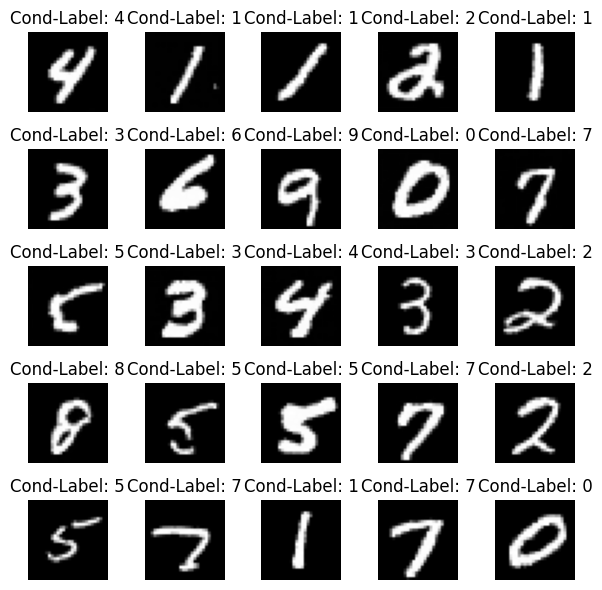

In [20]:
# Load model and config
cfg = CONFIG()

# Generate
generated_imgs = []
cond_labels = []
for i in range(25):
    y = np.random.randint(0, 10) # Randomly select a label bw 1 to 10.
    xt = generate(cfg, y)
    generated_imgs.append(xt)
    cond_labels.append(y)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(6, 6))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i], cmap='gray')  # You might need to adjust the colormap based on your images
    ax.set_title(f'Cond-Label: {cond_labels[i]}')
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Generate with 250 sampling Steps

251it [00:03, 63.42it/s]
251it [00:03, 63.24it/s]
251it [00:03, 63.21it/s]
251it [00:03, 63.06it/s]
251it [00:03, 63.08it/s]
251it [00:03, 63.34it/s]
251it [00:03, 63.05it/s]
251it [00:03, 63.23it/s]
251it [00:03, 63.28it/s]
251it [00:03, 64.84it/s]
251it [00:03, 64.48it/s]
251it [00:03, 64.71it/s]
251it [00:03, 63.18it/s]
251it [00:03, 63.64it/s]
251it [00:03, 63.18it/s]
251it [00:03, 63.14it/s]
251it [00:03, 63.58it/s]
251it [00:03, 63.50it/s]
251it [00:03, 63.15it/s]
251it [00:03, 63.17it/s]
251it [00:03, 63.11it/s]
251it [00:03, 63.32it/s]
251it [00:03, 63.32it/s]
251it [00:03, 63.44it/s]
251it [00:03, 63.32it/s]


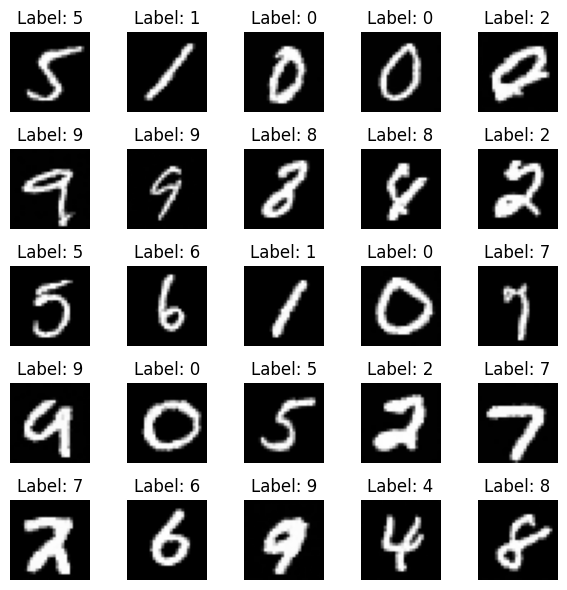

In [21]:
# Load config
cfg = CONFIG()
cfg.num_sampling_timesteps = 250 # Set timesteps to 250

# Generate
generated_imgs = []
cond_labels = []
for i in range(25):
    y = np.random.randint(0, 10) # Randomly select a label bw 1 to 10.
    xt = generate(cfg, y)
    generated_imgs.append(xt)
    cond_labels.append(y)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(6, 6))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i], cmap='gray')  # You might need to adjust the colormap based on your images
    ax.set_title(f'Label: {cond_labels[i]}')
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

**Observation:**

* Visually speaking, Images sampled with 250 timesteps looks pretty good.
* The time taken to generate per image is also reduced by 3/4 times.

### Classifier Guidance + 1000 sampling steps

1000it [00:40, 24.58it/s]
1000it [00:40, 24.74it/s]
1000it [00:40, 24.63it/s]
1000it [00:40, 24.75it/s]
1000it [00:40, 24.79it/s]
1000it [00:40, 24.75it/s]
1000it [00:40, 24.55it/s]
1000it [00:41, 24.20it/s]
1000it [00:40, 24.70it/s]
1000it [00:40, 24.72it/s]
1000it [00:40, 24.73it/s]
1000it [00:40, 24.69it/s]
1000it [00:40, 24.76it/s]
1000it [00:40, 24.69it/s]
1000it [00:41, 24.19it/s]
1000it [00:40, 24.68it/s]
1000it [00:40, 24.71it/s]
1000it [00:40, 24.70it/s]
1000it [00:40, 24.72it/s]
1000it [00:40, 24.65it/s]
1000it [00:40, 24.68it/s]
1000it [00:41, 24.34it/s]
1000it [00:41, 24.39it/s]
1000it [00:40, 24.55it/s]
1000it [00:40, 24.55it/s]


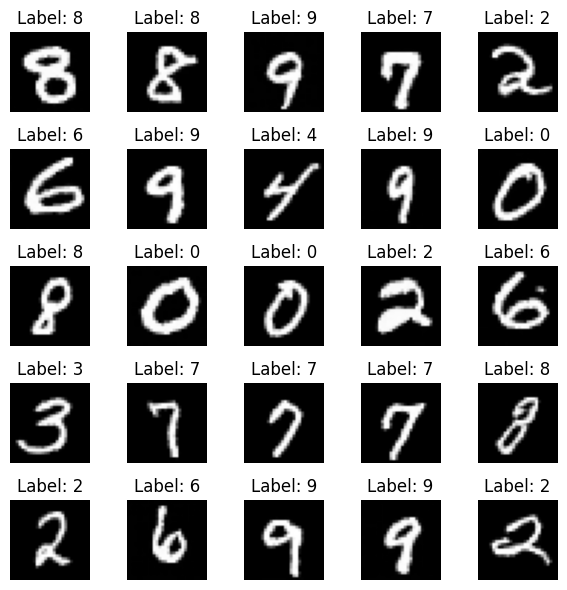

In [22]:
# Load model and config
cfg = CONFIG()
cfg.classifier_guidance = True

# Generate
generated_imgs = []
cond_labels = []
for i in range(25):
    y = np.random.randint(0, 10) # Randomly select a label bw 1 to 10.
    xt = generate(cfg, y)
    generated_imgs.append(xt)
    cond_labels.append(y)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(6, 6))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i], cmap='gray')  # You might need to adjust the colormap based on your images
    ax.set_title(f'Label: {cond_labels[i]}')
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Classifier Guidance + 250 sampling steps

251it [00:10, 24.62it/s]
251it [00:10, 24.64it/s]
251it [00:10, 24.68it/s]
251it [00:10, 24.62it/s]
251it [00:10, 24.73it/s]
251it [00:10, 24.00it/s]
251it [00:10, 24.01it/s]
251it [00:10, 24.17it/s]
251it [00:10, 24.21it/s]
251it [00:10, 24.18it/s]
251it [00:10, 24.03it/s]
251it [00:10, 24.07it/s]
251it [00:10, 24.20it/s]
251it [00:10, 24.21it/s]
251it [00:10, 24.57it/s]
251it [00:10, 24.38it/s]
251it [00:10, 23.60it/s]
251it [00:10, 23.91it/s]
251it [00:10, 24.51it/s]
251it [00:10, 24.13it/s]
251it [00:10, 24.38it/s]
251it [00:10, 24.61it/s]
251it [00:10, 24.57it/s]
251it [00:10, 24.60it/s]
251it [00:10, 24.56it/s]


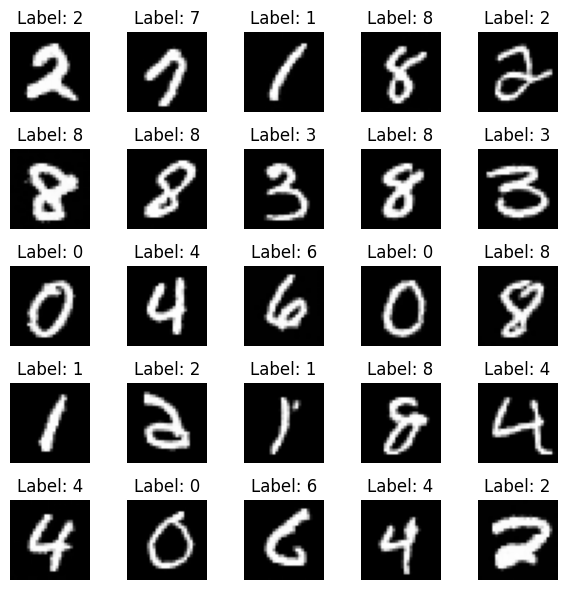

In [23]:
# Load config
cfg = CONFIG()
cfg.classifier_guidance = True
cfg.num_sampling_timesteps = 250 # Set timesteps to 250

# Generate
generated_imgs = []
cond_labels = []
for i in range(25):
    y = np.random.randint(0, 10) # Randomly select a label bw 1 to 10.
    xt = generate(cfg, y)
    generated_imgs.append(xt)
    cond_labels.append(y)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(5, 5, figsize=(6, 6))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i], cmap='gray')  # You might need to adjust the colormap based on your images
    ax.set_title(f'Label: {cond_labels[i]}')
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Performance Evaluation

## References

* [Improved Denoising Diffusion Probabilistic Models](https://proceedings.mlr.press/v139/nichol21a/nichol21a.pdf)
* [Diffusion Models Beat GANs on Image Synthesis](https://openreview.net/pdf?id=AAWuCvzaVt)
* [DDPM from scratch in Pytorch](https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch?rvi=1)